# gpt1 아키텍처로 만드는 대화형 챗봇
트랜스포머를 변형한 gpt1 챗봇 만들기

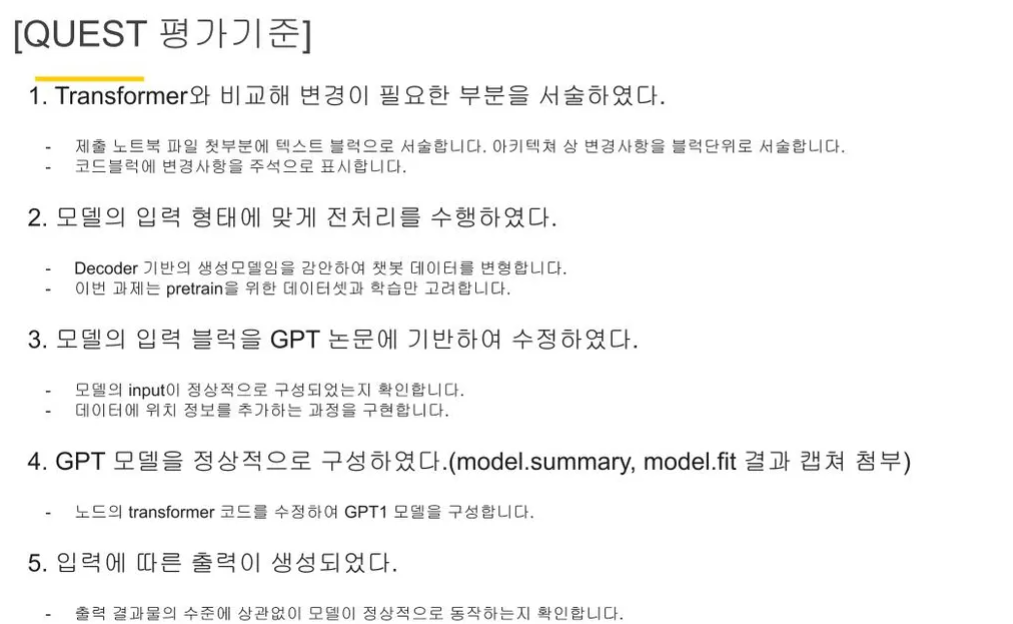

## 트랜스포머 아키텍처
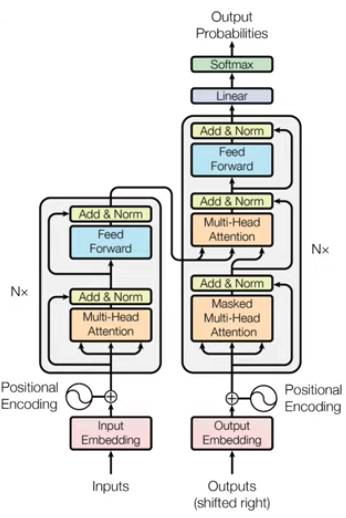

## gpt1 아키텍처
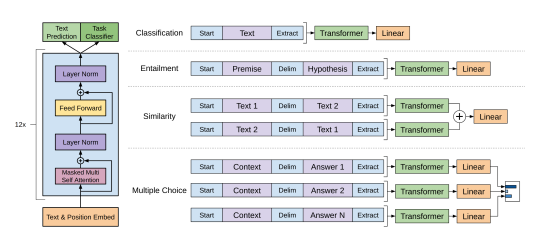

## 전략
### 트랜스포머 seq2seq 모델 -> GPT-1 모델 변환
GPT는 transformer Decoder를 활용한 Pretrained LM
- 인코더 구조 삭제하고 디코더만을 사용하는 트랜스포머 모델로 변형
- 입력을 토큰 임베딩 및 위치 인코딩을 통해 처리

1) 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### (gpt1) 포지셔널 행렬 구현
- Decorder 기반의 구조에 맞춰 변형. 마스킹 기법과 결합

In [2]:
class GPTPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(GPTPositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


### (gpt1) 스케일드 닷 프로덕트 어텐션 함수 구현
- 미래 토큰에 접근하지 못하도록 look-ahead masking 적용
- 쿼리와 키의 dot product 계산. 소프트맥스 함수로 정규화한 후 값와의 dot product 구함

In [3]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output

### (gpt1) 멀티헤드 어텐션 구현
- 기존 트랜스포머 모델과 비교해 인코더 없이 디코더만을 사용해 미래 정보 차단을 핵심으로 함.
- 입력으로 쿼리, 키, 값 을 받아야하기에 디코더에 입력하기 위한 변형

In [4]:
class GPTMultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(GPTMultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(d_model)
        self.key_dense = tf.keras.layers.Dense(d_model)
        self.value_dense = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, query, key, value, mask):
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        attention = scaled_dot_product_attention(query, key, value, mask)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)
        return output


### 록 어헤드 마스킹
다음 단어 가리기
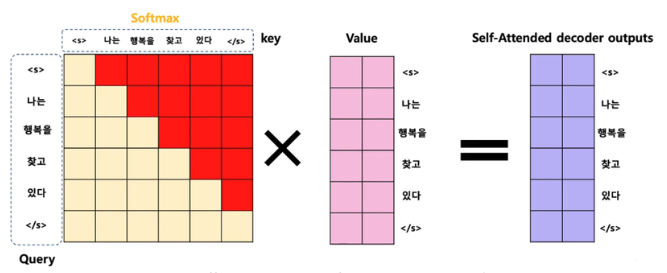
- 패딩 마스크와 함께 룩 어헤드 마스크 변형

In [5]:
# 패딩 마스크
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]


In [6]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### (gpt1) 디코더 구현
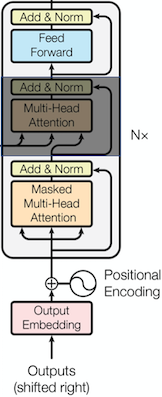

In [7]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.mha = GPTMultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)

    def call(self, x, look_ahead_mask):
        attn_output = self.mha(x, x, x, look_ahead_mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

### (gpt1) 디코더 층을 쌓아 전체 디코더 만들기

In [8]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, maximum_position_encoding, dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = GPTPositionalEncoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, dropout) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, look_ahead_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, look_ahead_mask)
        return x

## Chatbot 데이터 수집 및 전처리

In [9]:
import pandas as pd
import tensorflow_datasets as tfds

data_path = 'ChatbotData.csv'
chatbot_data_path = pd.read_csv(data_path)

# Q와 A 열을 각각 리스트로 변환
questions = []
answers = []

# 질문과 답변 데이터를 리스트에 추가
for index, row in chatbot_data_path.iterrows():
    questions.append(row['Q'])  # 질문 리스트에 추가
    answers.append(row['A'])  # 답변 리스트에 추가


In [10]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [11]:
print('전처리 후의 30번째 질문 샘플: {}'.format(questions[30]))
print('전처리 후의 30번째 답변 샘플: {}'.format(answers[30]))

전처리 후의 30번째 질문 샘플: 가족들이랑 서먹해
전처리 후의 30번째 답변 샘플: 다들 바빠서 이야기할 시간이 부족했나봐요.


In [12]:
# 데이터 전처리
def preprocess_sentence(sentence):
    sentence = sentence.lower()  # 소문자 변환
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 구두점 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)  # 중복된 공백 제거
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)  # 한글과 구두점 제외 제거
    sentence = sentence.strip()
    return sentence

# 전처리 적용
chatbot_data_path['Q'] = chatbot_data_path['Q'].apply(preprocess_sentence)
chatbot_data_path['A'] = chatbot_data_path['A'].apply(preprocess_sentence)

print(chatbot_data_path.head())

                Q             A  label
0           시 땡 !   하루가 또 가네요 .      0
1      지망 학교 떨어졌어    위로해 드립니다 .      0
2     박 일 놀러가고 싶다  여행은 언제나 좋죠 .      0
3  박 일 정도 놀러가고 싶다  여행은 언제나 좋죠 .      0
4             심하네   눈살이 찌푸려지죠 .      0


In [13]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


In [14]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


In [15]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5759, 607, 2490, 4160]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7510, 5, 6273, 94, 7960]


In [16]:
# 샘플 길이 확인
q_len = [len(s.split()) for s in questions]
a_len = [len(s.split()) for s in answers]

print('질문의 최소 길이 : {}'.format(np.min(q_len)))
print('질문의 최대 길이 : {}'.format(np.max(q_len)))
print('질문의 평균 길이 : {}'.format(np.mean(q_len)))
print('답변의 최소 길이 : {}'.format(np.min(a_len)))
print('답변의 최대 길이 : {}'.format(np.max(a_len)))
print('답변의 평균 길이 : {}'.format(np.mean(a_len)))

질문의 최소 길이 : 1
질문의 최대 길이 : 15
질문의 평균 길이 : 3.587414361837097
답변의 최소 길이 : 1
답변의 최대 길이 : 21
답변의 평균 길이 : 3.6936479742874058


In [17]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 21
print(MAX_LENGTH)

21


In [18]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 21 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 21으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11800
필터링 후의 답변 샘플 개수: 11800


In [19]:
# 토큰화된 결과 확인
sample_sentence = "안녕하세요"
encoded_sentence = tokenizer.encode(sample_sentence)
print("인코더 문장:", encoded_sentence)
decoded_sentence = tokenizer.decode(encoded_sentence)
print("디코더 문장:", decoded_sentence)

인코더 문장: [4151]
디코더 문장: 안녕하세요


In [20]:
import numpy as np
import tensorflow as tf

# questions와 answers 데이터를 예시로 설정
questions = np.array(questions)  # 질문 데이터를 배열로 변환
answers = np.array(answers)  # 답변 데이터를 배열로 변환

# questions와 answers를 2차원 배열로 변환 (배치 크기, 시퀀스 길이)
questions = np.reshape(questions, (len(questions), -1))
answers = np.reshape(answers, (len(answers), -1))

# axis=1을 기준으로 결합
combined_data = np.concatenate([questions, answers], axis=1)

# 입력 데이터는 마지막 토큰을 제외한 모든 토큰으로 설정
inputs = combined_data[:, :-1]

# 출력 데이터는 첫 번째 토큰을 제외한 나머지 토큰으로 설정
outputs = combined_data[:, 1:]

# 데이터셋 설정
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print(f'데이터셋 준비 완료: 총 {len(combined_data)}개의 샘플')


데이터셋 준비 완료: 총 11800개의 샘플


### GPT-1 모델 정의

In [31]:
def gpt1_model(vocab_size,
               num_layers,
               d_model,
               num_heads,
               dff,
               dropout,
               maximum_position_encoding,
               name="gpt1_model"):
    
    # GPT-1 단일 시퀀스를 입력으로 받기
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # GPT-1 는 룩어헤드 마스크만 사용하여 향후 토큰에 참석하지 못하도록 한다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='create_look_ahead_mask')(dec_inputs)

    # GPT-1 디코더 레이어 스택 사용
    dec_outputs = Decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        dropout=dropout,
        maximum_position_encoding=maximum_position_encoding,
    )(inputs=[inputs, look_ahead_mask, None])

    # 출력 레이어(소프트맥스에 대한 vocab_size 단위)
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(dec_inputs=dec_inputs, outputs=outputs, name=name)


In [32]:
tf.keras.backend.clear_session()

# GPT-1 모델 하이퍼파라미터
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT_RATE = 0.1
VOCAB_SIZE = 5000  # 예시로 설정한 값
MAX_SEQ_LEN = 100

# GPT-1 모델 생성
model = gpt1_model(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    dropout=DROPOUT_RATE,
    maximum_position_encoding=MAX_SEQ_LEN
)

model.summary()

ValueError: The first argument to `Layer.call` must always be passed.

### 손실 함수

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 커스텀된 학습률 사용

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 모델 평가하기
모델 컴파일

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
# 모델 학습
EPOCHS = 50  # 학습할 에포크 수

history = model.fit(dataset, epochs=EPOCHS)